# Online Retail Sales EDA – Customer Behavior & Sales Analysis

##  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


##  Load Dataset & Initial Exploration

In [2]:
# load dataset
df = pd.read_excel('online_retail.xlsx')

# First few rows 
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.shape

(525461, 8)


The dataset contains **525461** rows and **8** columns.

In [4]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316



Quantity and Price have extreme values ( Quantity min = -9600, Price min = -53594.36) which indicate potential outliers or data entry errors.

Customer ID has missing values, as seen from the count being lower than other columns.

##  Data Cleaning & Preprocessing

In [7]:
# check for missing values
(df.isnull().sum() / len(df))*100

Invoice         0.000000
StockCode       0.000000
Description     0.557225
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    20.539488
Country         0.000000
dtype: float64

Customer ID has **20.54%** missing values 

Description has **0.56%** missing values 

In [8]:
# Drop rows with missing Customer ID 
df = df[df['Customer ID'].notna()].copy()

#  fill missing Description values
df['Description'] = df['Description'].fillna('Missing Description')

# check again for missing values
print(df.isnull().mean() * 100)

Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
Customer ID    0.0
Country        0.0
dtype: float64


In [9]:
# Remove duplicate rows 
df = df.drop_duplicates()

# Check shape after duplicates removed
print("Data shape after removing duplicates:", df.shape)

Data shape after removing duplicates: (410763, 8)


In [10]:
df['Invoice'].value_counts().index

Index([   500356,    507235,    526089,    511522,    511051,    531382,
          525928,    532993,    534187,    493812,
       ...
          517197, 'C517219', 'C530287', 'C530285', 'C530284', 'C530282',
       'C530279',    517214,    517215, 'C503745'],
      dtype='object', name='Invoice', length=23587)



Some invoice numbers start with **'C'**, which typically indicates **canceled orders**

In [11]:
#  Ensure Invoice column is treated as string
df['Invoice'] = df['Invoice'].astype(str)

#  Remove rows where Invoice starts with 'C'
df = df[~df['Invoice'].str.startswith('C')]

# Check shape after removing
print("Shape after removing canceled orders:", df.shape)


Shape after removing canceled orders: (400947, 8)


In [12]:
def check_outliers_iqr(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    print(f"Outliers in {column}: {outliers.shape[0]}")

# Check outliers in Quantity and Price
check_outliers_iqr('Quantity')
check_outliers_iqr('Price')


Outliers in Quantity: 26296
Outliers in Price: 32623


In [13]:
def cap_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Clip values to within the IQR bounds
    df[column] = df[column].clip(lower=lower, upper=upper)

# capping to Quantity and Price
cap_outliers('Quantity')
cap_outliers('Price')


In [14]:
print("Invalid Quantity values (<= 0):", (df['Quantity'] <= 0).sum())
print("Invalid Price values (<= 0):", (df['Price'] <= 0).sum())

Invalid Quantity values (<= 0): 0
Invalid Price values (<= 0): 31


In [15]:
df = df[df['Price'] > 0]

##  General Overview of the Dataset

In [16]:
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['axes.facecolor'] = 'white'

Unique products: 4017


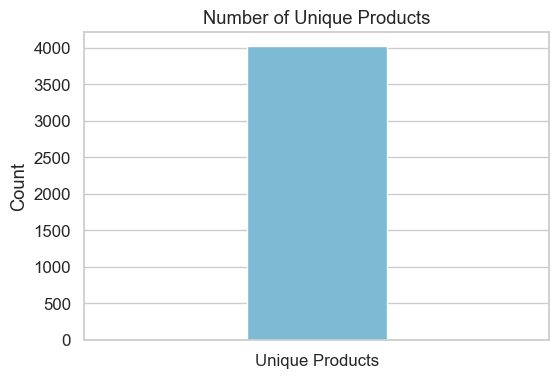

In [17]:
# Count unique products using StockCode
unique_products = df['StockCode'].nunique()
print("Unique products:", unique_products)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Unique Products'], y=[unique_products], palette=["#6EC1E4"], width=0.3)
plt.title('Number of Unique Products')
plt.ylabel('Count')
plt.show()


The dataset contains **4017** unique products.

Total Transactions (Invoices): 19213


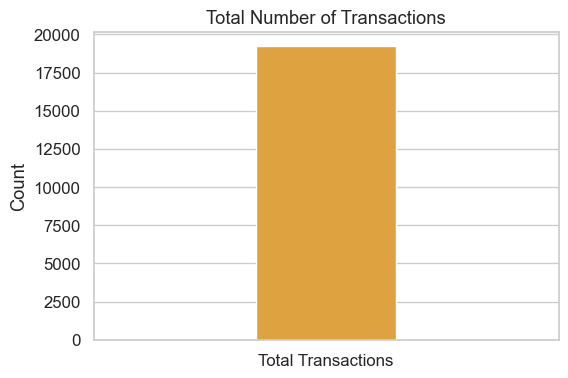

In [18]:
# Count unique invoices
total_transactions = df['Invoice'].nunique()
print("Total Transactions (Invoices):", total_transactions)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Total Transactions'], y=[total_transactions], palette=["#F9A825"], width=0.3)
plt.title('Total Number of Transactions')
plt.ylabel('Count')
plt.show()


There are **19213** unique transactions in the dataset.

Unique Customers: 4312


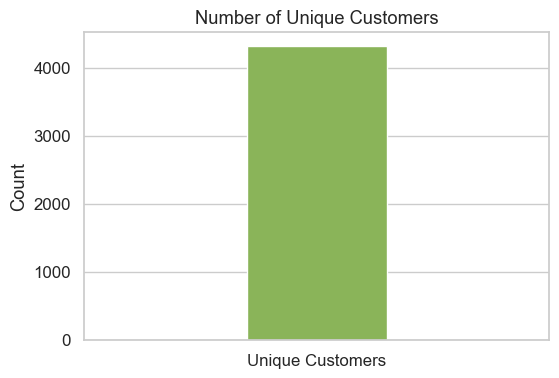

In [19]:
# Count unique customers
unique_customers = df['Customer ID'].nunique()
print("Unique Customers:", unique_customers)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=['Unique Customers'], y=[unique_customers], palette=["#8BC34A"], width=0.3)
plt.title('Number of Unique Customers')
plt.ylabel('Count')
plt.show()


The dataset contains **4312** unique customers

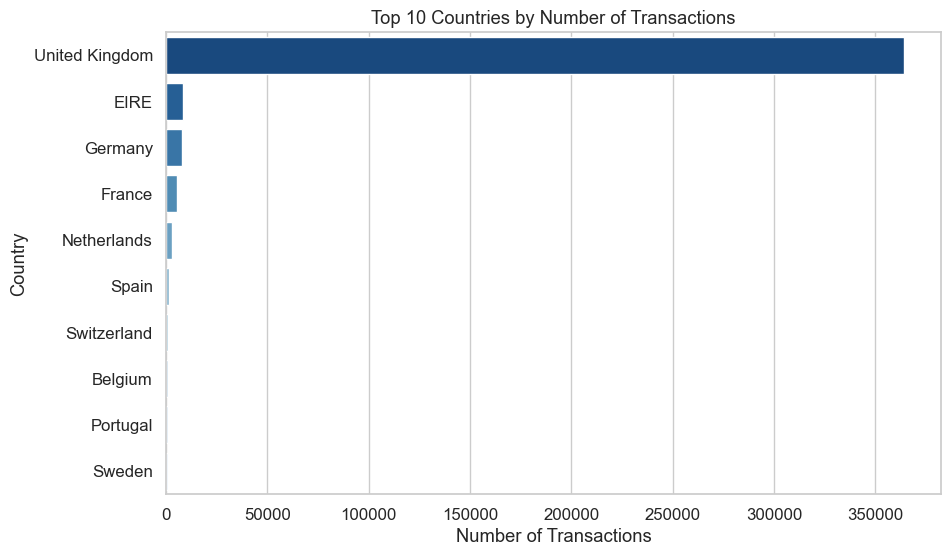

In [20]:
# Count customers by country
country_counts = df['Country'].value_counts().sort_values(ascending=False)

# Plot top 10 countries
plt.figure(figsize=(10,6))
sns.barplot(y=country_counts.head(10).index, x=country_counts.head(10).values, palette="Blues_r")
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()


The **United Kingdom** typically has the **highest** number of transactions.

##  Product Analysis

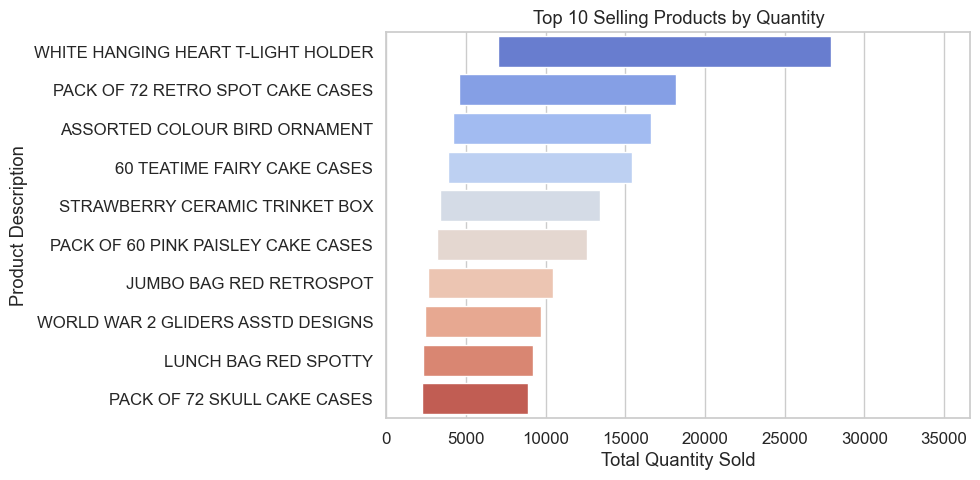

In [21]:
# Group by Description and sum Quantity
top_selling = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_selling.values, y=top_selling.index, palette='coolwarm')
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)
plt.title('Top 10 Selling Products by Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


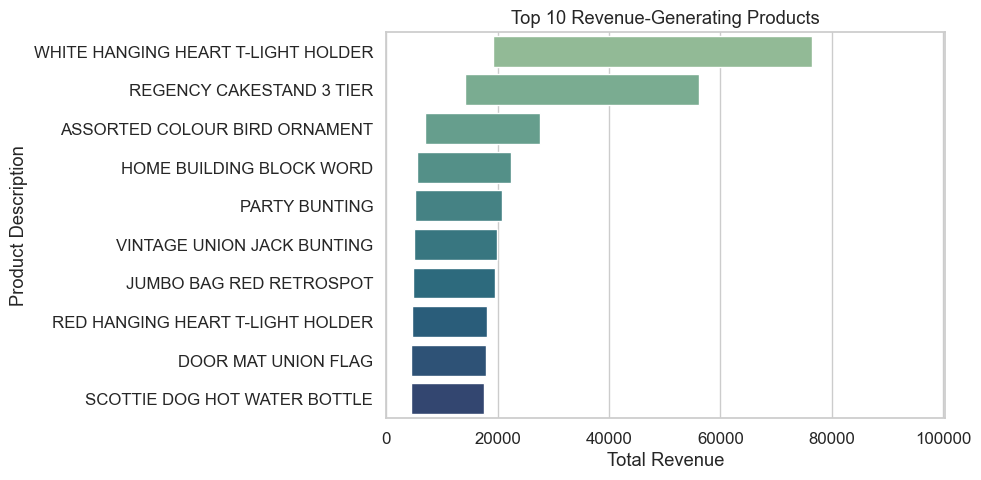

In [22]:
# Create Revenue column
df['Revenue'] = df['Quantity'] * df['Price']
# Group by Description and sum Revenue
top_revenue = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_revenue.values, y=top_revenue.index, palette='crest')
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)
plt.title('Top 10 Revenue-Generating Products')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()


##  Customer Analysis

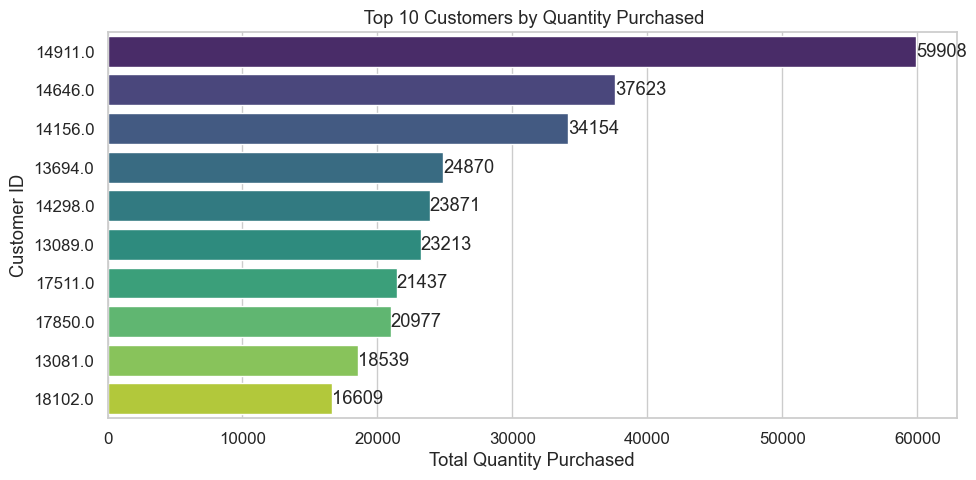

In [23]:
# Top 10 customers by quantity purchased
top_customers = df.groupby('Customer ID')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_customers.values, y=top_customers.index.astype(str), palette="viridis")
for i, (value, name) in enumerate(zip(top_customers.values, top_customers.index)):
    plt.text(value + 1, i, str(value), va='center')
plt.title(' Top 10 Customers by Quantity Purchased')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()


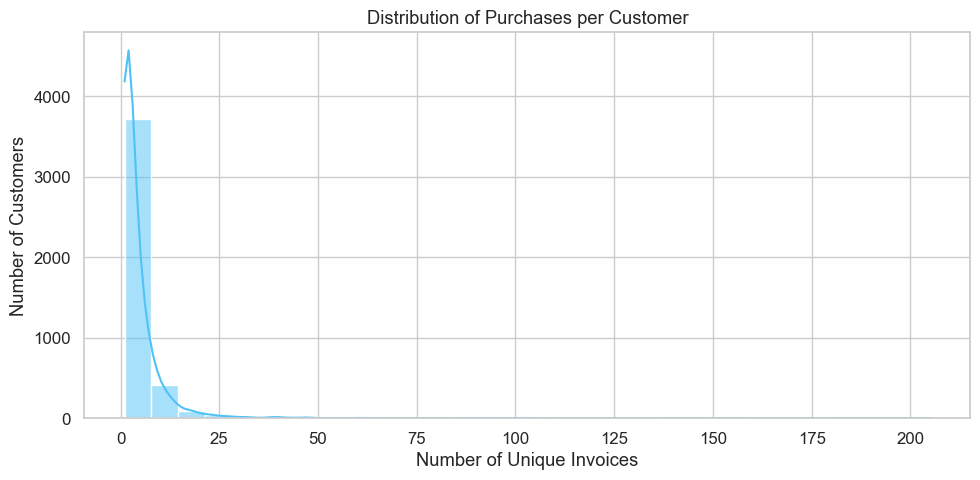

In [24]:
# Count number of purchases (invoices) per customer
purchases_per_customer = df.groupby('Customer ID')['Invoice'].nunique()

# Plot
plt.figure(figsize=(10,5))
sns.histplot(purchases_per_customer, bins=30, kde=True, color='#4FC3F7')
plt.title('Distribution of Purchases per Customer')
plt.xlabel('Number of Unique Invoices')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


Number of loyal customers: 18
Customer ID
14911.0    205
17850.0    155
12748.0    144
15311.0    121
13089.0    109
14156.0    102
14606.0    102
13694.0     94
17841.0     91
18102.0     89
Name: Invoice, dtype: int64


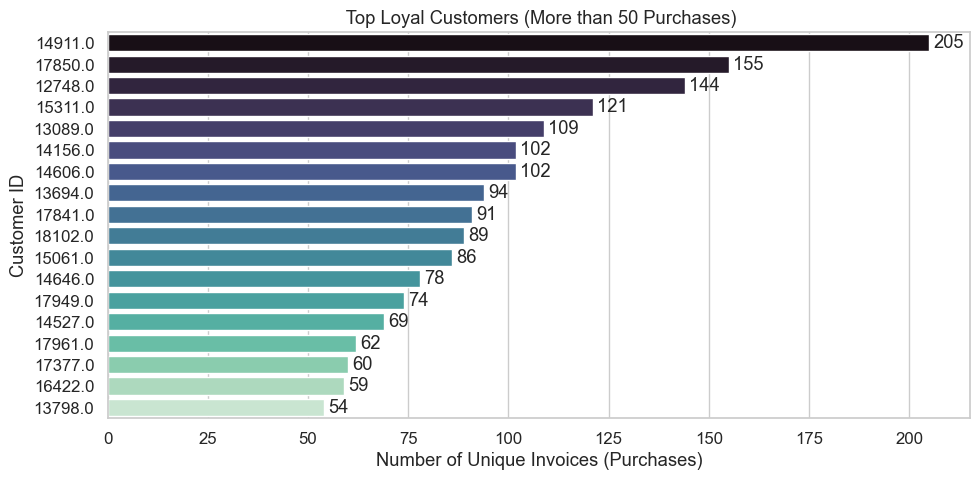

In [25]:
# Find loyal customers (more than 50 unique invoices)
purchases_per_customer = df.groupby('Customer ID')['Invoice'].nunique()
loyal_customers = purchases_per_customer[purchases_per_customer > 50]

print("Number of loyal customers:", loyal_customers.shape[0])
print(loyal_customers.sort_values(ascending=False).head(10))

# Plot Top 10 loyal customers
top_loyal = loyal_customers.sort_values(ascending=False).head(50)

plt.figure(figsize=(10,5))
ax = sns.barplot(x=top_loyal.values, y=top_loyal.index.astype(str), palette="mako")

# Add text labels on bars
for i, (value, name) in enumerate(zip(top_loyal.values, top_loyal.index)):
    plt.text(value + 1, i, str(value), va='center')

plt.title(' Top Loyal Customers (More than 50 Purchases)')
plt.xlabel('Number of Unique Invoices (Purchases)')
plt.ylabel('Customer ID')
plt.tight_layout()
plt.show()



**18** customers made more than 50 purchases, showing strong loyalty.


##  Time Series & Seasonal Trends

In [26]:
# Create Revenue column
df['Revenue'] = df['Quantity'] * df['Price']

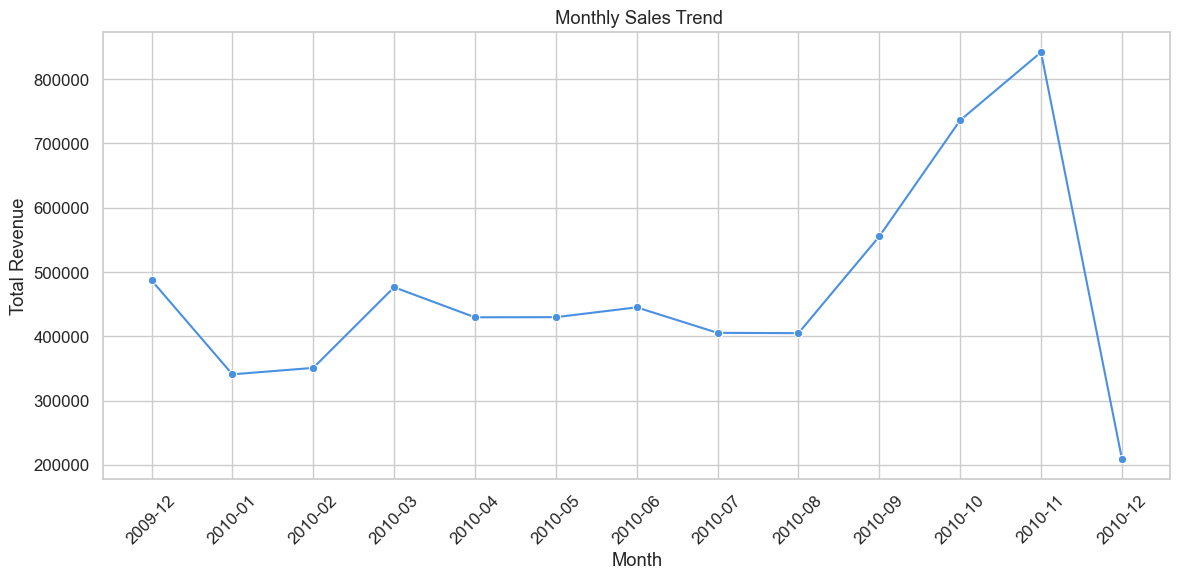

In [27]:
# Extract Year-Month from InvoiceDate
df['Month'] = df['InvoiceDate'].dt.to_period('M').astype(str)

# Group by Month and sum revenue
monthly_sales = df.groupby('Month')['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='Month', y='Revenue', marker='o', color="#4A90E2")
plt.xticks(rotation=45)
plt.title(' Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()


Peak Month: **11** with revenue $841854

Slow Month: **12** with revenue $209780

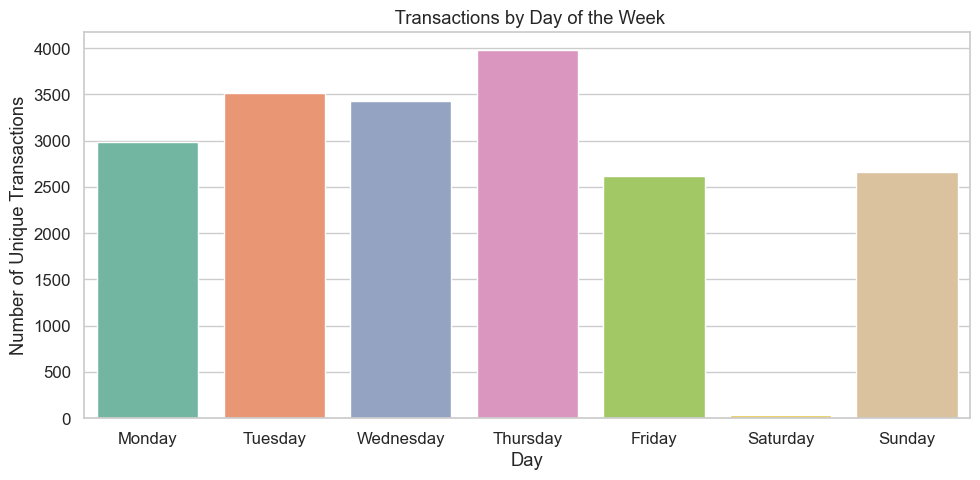

In [28]:
# Extract day of week 
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

# Group by DayOfWeek and count transactions
daily_orders = df.groupby('DayOfWeek')['Invoice'].nunique().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=daily_orders.index, y=daily_orders.values, palette="Set2")
plt.title(' Transactions by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Unique Transactions')
plt.tight_layout()
plt.show()


Certain weekdays, like **Thursday**, show higher customer activity, while **Saturday** are relatively slower.

##  Country-wise Sales Analysis

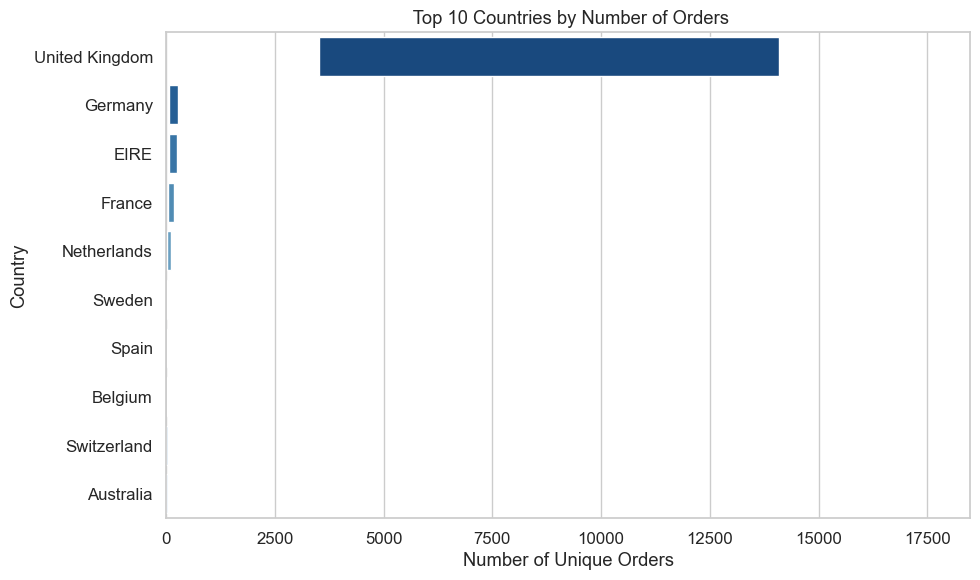

In [29]:
# Count unique invoices per country
orders_by_country = df.groupby('Country')['Invoice'].nunique().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=orders_by_country.values, y=orders_by_country.index, palette="Blues_r")
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)
plt.title(" Top 10 Countries by Number of Orders")
plt.xlabel("Number of Unique Orders")
plt.ylabel("Country")
plt.tight_layout()
plt.show()



The United Kingdom leads by a wide margin, followed by other European countries.

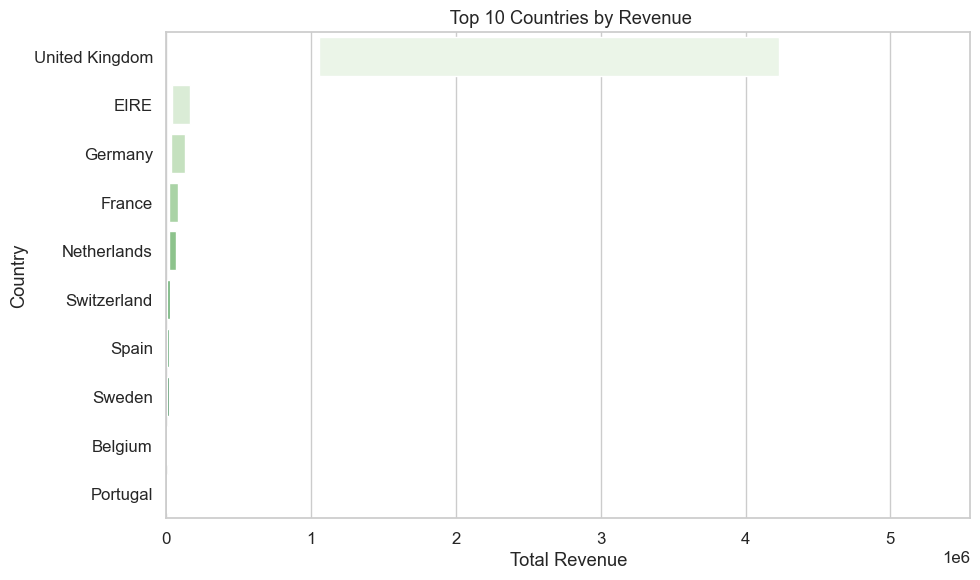

In [30]:
# Sum total revenue per country
revenue_by_country = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(x=revenue_by_country.values, y=revenue_by_country.index, palette="Greens")

# Slim the bars
for patch in ax.patches:
    width = patch.get_width()
    patch.set_width(width * 0.6)
    patch.set_x(patch.get_x() + width * 0.2)

plt.title(" Top 10 Countries by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


The United Kingdom dominates in total revenue, aligning with the number of orders.

Countries like the Netherlands, EIRE (Ireland), and Germany also contribute significantly to the revenue stream.

##  RFM Customer Segmentation

Recency: Days since the last purchase

Frequency: Number of unique transactions

Monetary: Total amount spent

In [31]:
import datetime as dt

# Reference date: one day after the last purchase in the data
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'Revenue': 'sum'                                           # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Display RFM table
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,11,372.86
1,12347.0,3,2,1297.97
2,12348.0,74,1,222.16
3,12349.0,43,3,2011.34
4,12351.0,11,1,295.68


The resulting RFM table provides a customer-wise summary of how recently, how often, and how much they purchased. This will be used in the next step for customer segmentation.

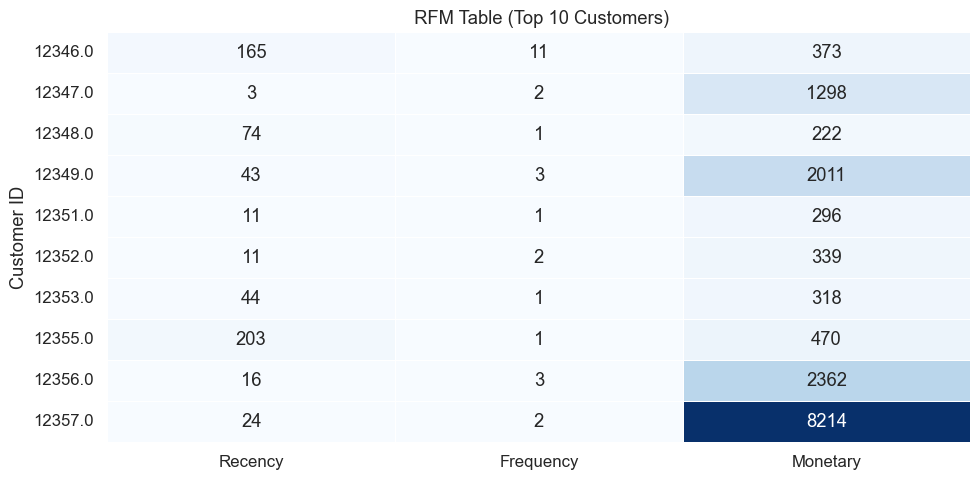

In [32]:
# Pick top 10 customers
rfm_table = rfm.head(10).set_index('Customer ID')[['Recency', 'Frequency', 'Monetary']]

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(rfm_table, annot=True, fmt=".0f", cmap='Blues', linewidths=0.5, cbar=False)
plt.title(" RFM Table (Top 10 Customers)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
# Assign scores using quartiles (qcut automatically handles binning)
rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1]).astype(int)  # Lower is better
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)

# Create RFM Segment Code
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Display top
rfm.head()


,Customer ID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,165,11,372.86,1,4,2,142
1,12347.0,3,2,1297.97,4,2,3,423
2,12348.0,74,1,222.16,2,1,1,211
3,12349.0,43,3,2011.34,3,3,4,334
4,12351.0,11,1,295.68,4,1,2,412


In [34]:
def segment_customer(row):
    if row['RFM_Score'] == '444':
        return 'Top Customer'
    elif row['R'] >= 3 and row['F'] >= 3:
        return 'Loyal Customer'
    elif row['R'] >= 3:
        return 'Recent Customer'
    elif row['F'] >= 3:
        return 'Frequent Buyer'
    elif row['M'] >= 3:
        return 'Big Spender'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


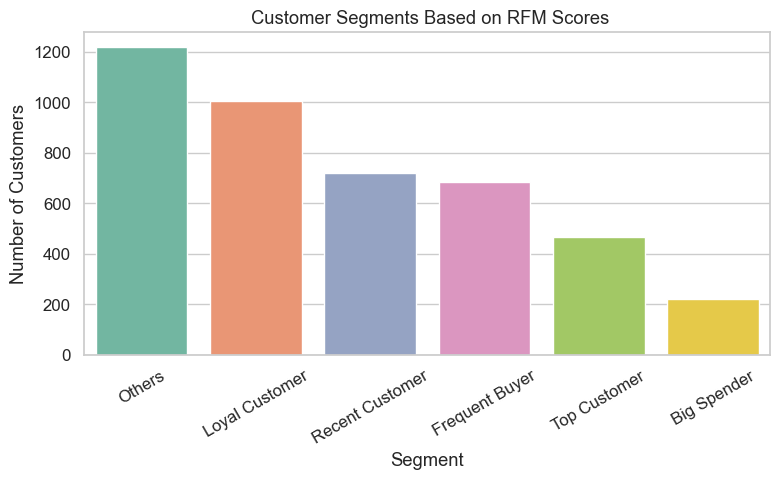

In [35]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.title(' Customer Segments Based on RFM Scores')
plt.ylabel('Number of Customers')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Majority of customers fall under the Loyal Customer and Others segments.


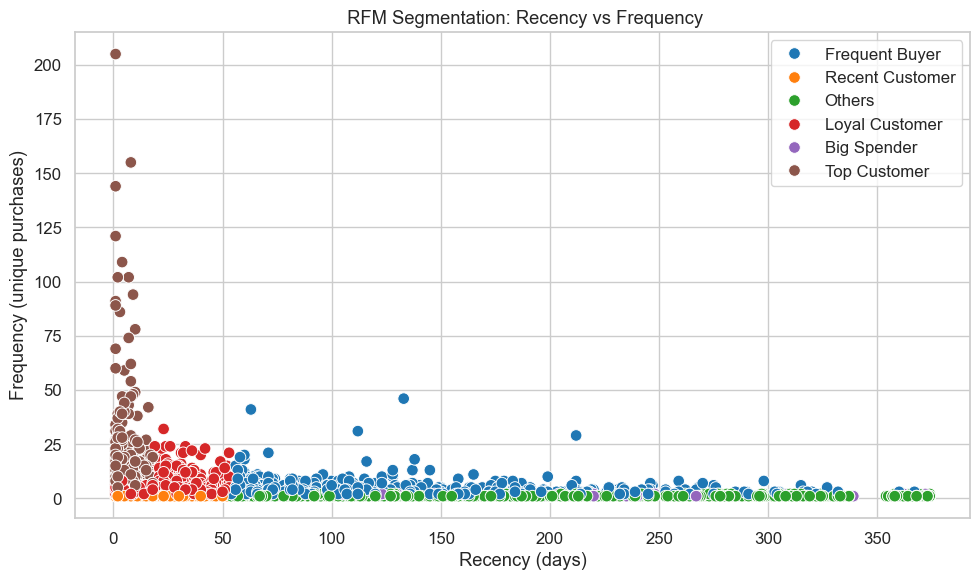

In [36]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='tab10', s=70)
plt.title(' RFM Segmentation: Recency vs Frequency')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (unique purchases)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
df.to_csv("cleaned_online_retail.csv", index=False)

rfm.to_csv("rfm_segments.csv", index=False)